In [1]:
import sys
sys.path.append("../")

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

2023-05-16 12:44:23.931881: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
def generate_test_data(test_df, image_type_path):
    clahe=cv2.createCLAHE(clipLimit=40)
    labels = []
    images = []
    for image_path, label in test_df[[image_type_path, "pathology"]].values:
        if image_path == "no":
            pass
        else:
            labels.append(label)
            image = cv2.imread(image_path, 0)
            gray_img_eqhist=cv2.equalizeHist(image)
            gray_clahe_image = cv2.cvtColor(clahe.apply(gray_img_eqhist), cv2.COLOR_GRAY2RGB)
            image = tf.image.resize(gray_clahe_image, (299, 299)).numpy().astype("uint8")
            images.append(image)
    return np.array(images), labels

In [4]:
train = pd.read_csv("../CBIS-DDSM/csv/calc_train_updated.csv", index_col=0)
test = pd.read_csv("../CBIS-DDSM/csv/calc_test_updated.csv", index_col=0)

In [5]:
new_dataset_train_path = "../image_dataset/calc_dataset/cropped_images/train/"
new_dataset_val_path = "../image_dataset/calc_dataset/cropped_images/validation/"
new_dataset_test_path = "../image_dataset/calc_dataset/cropped_images/test/"
BATCH_SIZE = 256
IMG_SIZE = 299

tf_train_dataset = tf.keras.utils.image_dataset_from_directory(new_dataset_train_path,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                              image_size=(299, 299))

tf_validation_dataset = tf.keras.utils.image_dataset_from_directory(new_dataset_val_path,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                   image_size=(299, 299))

tf_test_dataset = tf.keras.utils.image_dataset_from_directory(new_dataset_test_path,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                   image_size=(299, 299))

images, labels = generate_test_data(test, image_type_path="cropped image file path")

Found 1072 files belonging to 2 classes.
Metal device set to: Apple M1
Found 215 files belonging to 2 classes.
Found 259 files belonging to 2 classes.


2023-05-16 12:44:26.866699: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-16 12:44:26.866815: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


2023-05-16 01:20:00.350521: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [215]
	 [[{{node Placeholder/_4}}]]
2023-05-16 01:20:00.351088: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [215]
	 [[{{node Placeholder/_4}}]]


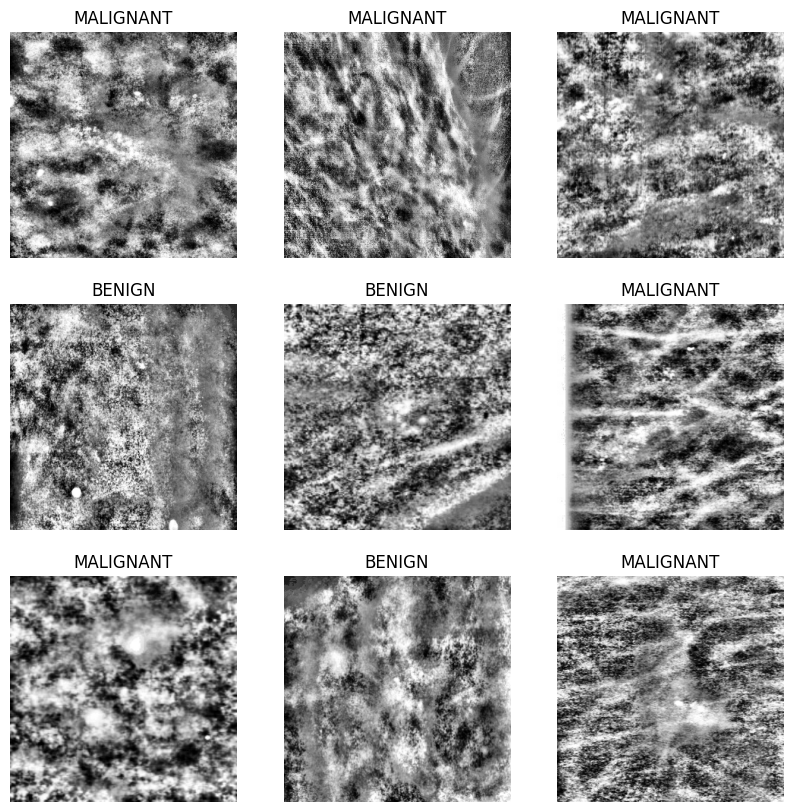

In [10]:
class_names = tf_train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in tf_validation_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [6]:
data_augmentation = tf.keras.Sequential([
    tf.keras. layers.RandomFlip("horizontal_and_vertical")])

preprocess_input = tf.keras.applications.inception_v3.preprocess_input

In [7]:
base_model = tf.keras.applications.InceptionV3(include_top=False, 
                                               input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                               weights='imagenet')

for layer in base_model.layers:
    layer.trainable = False
    
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

x = data_augmentation(inputs)
# x = preprocess_input(x)
x = base_model(x, training=False)
x = Flatten()(x)
x = Dense(1024*2, activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = Dense(1024*2, activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = Dense(32, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs, x)

model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), metrics=['accuracy'])

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 299, 299, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 2048)              268437504 
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 2048)              419635

In [8]:
history = model.fit(tf_train_dataset,
                    epochs=80,
                    batch_size=32,
                    validation_data=tf_test_dataset)

mets = model.evaluate(images, labels)
print("loss:", mets[0], "\naccuracy:", np.round(mets[1]*100, 4), "%")

Epoch 1/80


2023-05-16 02:18:59.452667: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1072]
	 [[{{node Placeholder/_4}}]]
2023-05-16 02:18:59.453132: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1072]
	 [[{{node Placeholder/_4}}]]
2023-05-16 02:19:02.350193: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - ETA: 0s - loss: 2.9143 - accuracy: 0.5019 

2023-05-16 02:20:47.491461: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [259]
	 [[{{node Placeholder/_4}}]]
2023-05-16 02:20:47.492897: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [259]
	 [[{{node Placeholder/_0}}]]
2023-05-16 02:20:48.524525: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 118s 25s/step - loss: 2.9143 - accuracy: 0.5019 - val_loss: 0.9581 - val_accuracy: 0.5328
Epoch 2/80
5/5 [==============================] - 110s 22s/step - loss: 1.6421 - accuracy: 0.5084 - val_loss: 1.5688 - val_accuracy: 0.5135
Epoch 3/80
5/5 [==============================] - 130s 25s/step - loss: 1.3035 - accuracy: 0.5513 - val_loss: 0.8248 - val_accuracy: 0.5946
Epoch 4/80
5/5 [==============================] - 98s 19s/step - loss: 1.1777 - accuracy: 0.5513 - val_loss: 0.9350 - val_accuracy: 0.5212
Epoch 5/80
5/5 [==============================] - 95s 19s/step - loss: 0.9873 - accuracy: 0.5373 - val_loss: 0.7112 - val_accuracy: 0.4981
Epoch 6/80
5/5 [==============================] - 91s 18s/step - loss: 0.8604 - accuracy: 0.5494 - val_loss: 0.7029 - val_accuracy: 0.5174
Epoch 7/80
5/5 [==============================] - 131s 26s/step - loss: 0.8172 - accuracy: 0.5261 - val_loss: 0.7014 - val_accuracy: 0.5019
Epoch 8/80
5/5 [==================

ValueError: Failed to find data adapter that can handle input: <class 'numpy.ndarray'>, (<class 'list'> containing values of types {"<class 'str'>"})

In [ ]:
mets = model.evaluate(images, labels)
print("loss:", mets[0], "\naccuracy:", np.round(mets[1]*100, 4), "%")

In [ ]:
y_pred = model.predict(tf_test_dataset)

print(classification_report(y_true=labels, y_pred=np.round(np.squeeze(y_pred))))

In [10]:
history = model.history

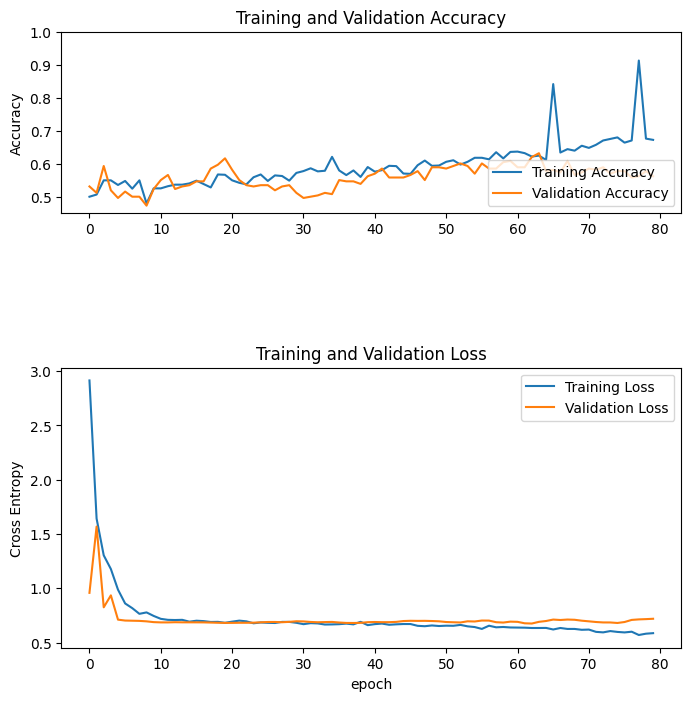

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(3, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()